## Kernel Galerkin

This notebook is for playing around with the kernel galerkin method, trying it out for a specific case and visualization

In [1]:
import sys
import os

project_root = os.path.abspath("..")  # If notebooks is one folder above src
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from src.eigensolver.galerkin.galerkin_eigensolver import GalerkinSolver
from src.energy.quadratic import QuadraticEnergy
from src.energy.gaussian_mixture import GaussianMixture
from src.eigensolver.galerkin.kernel_basis import KernelBasis
from src.eigensolver.galerkin.constant_basis import ConstantBasis
from src.eigensolver.galerkin.orthogonal_basis import OrthogonalBasis
from src.eigensolver.galerkin.kernels.gaussian_kernel import GaussianKernel
from src.eigensolver.galerkin.kernels.polynomial_kernel import PolynomialKernel
from src.metrics.eigen_evaluator import EigenEvaluator

/home/lclaeys/eigenfunction-solver/src/metrics/eigen_evaluator.py:60: SyntaxWarning: invalid escape sequence '\|'
  """


In [3]:
def kernel_experiment(experiment_params, energy, kernel_class = GaussianKernel):
    kernel_params = experiment_params['kernel_params']
    solver_params = experiment_params['solver_params']

    np.random.seed(42)
    dim = kernel_params['dim']
    x = energy.exact_sample((200000,))

    kernel = kernel_class(kernel_params)

    p = kernel_params['p']
    L_reg = solver_params['L_reg']
    k = solver_params['k']
    
    basis_points = energy.exact_sample((p,))
    basis = KernelBasis(kernel, basis_points)
    basis = ConstantBasis(basis)

    solver = GalerkinSolver(energy, x, solver_params)

    solver = solver.fit(basis,k=min(p-1,k),L_reg=L_reg)

    return x, solver

In [4]:
def plot_eigenfunctions(x,solver, k):
    l = 4
    fig, ax = plt.subplots(k//l,l,figsize=(20,k*1.2))
    fx = solver.predict(x)
    Lfx = solver.predict_Lf(x)
    for m in range(k):
        ax[m // l, m % l].hist2d(fx[:,m],Lfx[:,m],bins=50,cmap='viridis')
        ax[m // l, m % l].plot(fx[:,m],fx[:,m]*solver.eigvals[m],color='white')
        ax[m // l, m % l].set_xlabel("f(x)")
        ax[m // l, m % l].set_ylabel("Lf(x)")
        ax[m // l, m % l].set_title(f'Eigenvalue m = {m}, $\\lambda$ = {solver.eigvals[m]:.3f}')

### 1D Experiment

In [14]:
metrics = ['eigen_error','orth_error','eigen_cost', 'eigenvalue_mse','eigenfunc_mse', "fitted_eigenvalue_mse"]
experiment_params = {
    'kernel_params': {
        'dim': 1,
        'p': 500,
        'scale': 1.0,
        'order': 3
    },
    'solver_params': {
        'regularizer': 0.0,
        'L_reg': 1e-6,
        'verbose': False,
        'k': 4
    }
}

energy = QuadraticEnergy(np.eye(experiment_params['kernel_params']['dim']))

x, solver = kernel_experiment(experiment_params, energy, GaussianKernel)

if solver is None:
    print('Error')
else:
    evaluator = EigenEvaluator(energy)
    x_eval = energy.exact_sample((10000,))

    out = evaluator.evaluate_metrics(solver, x_eval, metrics, k = experiment_params['solver_params']['k'])
    for metric in metrics:
        print(f'{metric}: {out[metric]}')

eigen_error: [3.05712333e-08 8.70406861e-03 2.93991000e-02 1.98497698e-01]
orth_error: [1.27678623e-14 3.80512238e-04 1.03480125e-03 2.45986158e-03]
eigen_cost: [3.63560645e-05 1.01343218e+04 3.12173666e+04 6.51591277e+04]
eigenvalue_mse: [9.76094883e-13 9.58496020e-05 4.06759576e-03 4.35391216e-02]
eigenfunc_mse: [5.56550735e-10 7.50750142e-04 6.06950466e-02 6.49745950e-01]
fitted_eigenvalue_mse: [9.07301824e-15 1.56105486e-07 1.12894860e-06 1.10551237e-03]


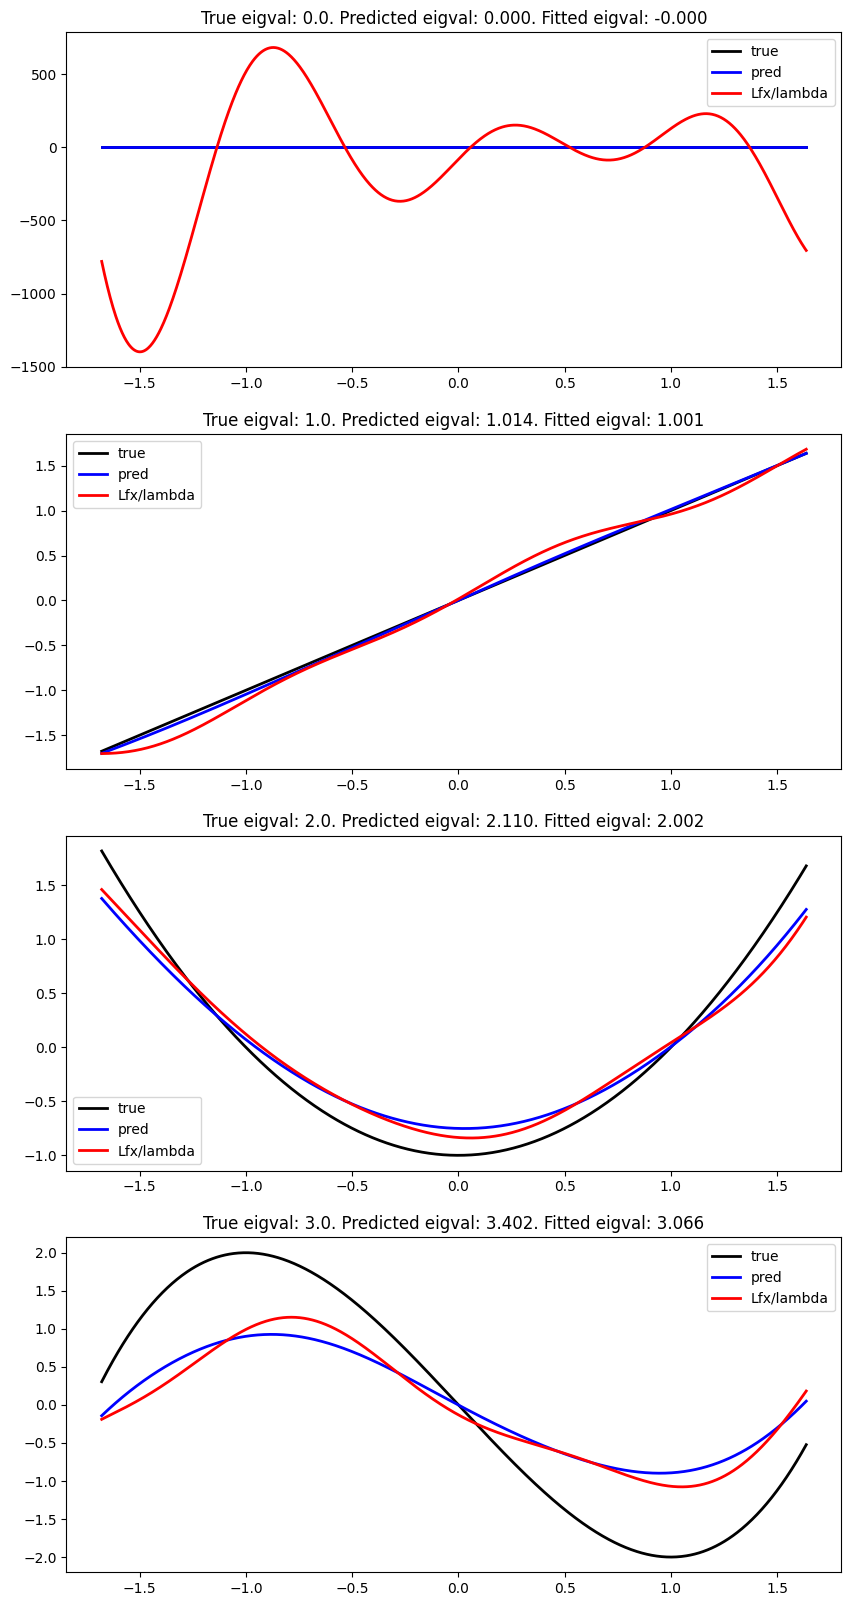

In [15]:
_ = evaluator.plot_eigfuncs_exact(solver,x_eval,4)

### 2D Experiment

In [16]:
metrics = ['eigen_error','orth_error','eigen_cost', 'eigenvalue_mse','eigenfunc_mse', "fitted_eigenvalue_mse"]
experiment_params = {
    'kernel_params': {
        'dim': 2,
        'p': 100,
        'scale': 5.0,
        'order': 3
    },
    'solver_params': {
        'regularizer': 0.0,
        'L_reg': 1e-6,
        'verbose': False,
        'k': 6
    }
}

energy = QuadraticEnergy(np.eye(experiment_params['kernel_params']['dim']))

x, solver = kernel_experiment(experiment_params, energy, GaussianKernel)

if solver is None:
    print('Error')
else:
    evaluator = EigenEvaluator(energy)
    x_eval = energy.exact_sample((10000,))

    out = evaluator.evaluate_metrics(solver, x_eval, metrics, k = experiment_params['solver_params']['k'])
    for metric in metrics:
        print(f'{metric}: {out[metric]}')

eigen_error: [7.49093514e-08 3.97003456e-03 4.49729793e-03 1.04690787e-02
 1.48195041e-02 1.63578892e-02]
orth_error: [1.35258653e-11 1.81731479e-04 1.44913221e-04 8.43650467e-04
 7.09813922e-04 6.54674061e-04]
eigen_cost: [1.84418927e-04 9.70453394e+03 1.95879919e+04 3.78812140e+04
 5.66619827e+04 7.58204152e+04]
eigenvalue_mse: [9.19815467e-13 3.79363623e-04 2.82704365e-04 6.62840822e-03
 7.81930313e-03 7.47627589e-03]
eigenfunc_mse: [5.19175450e-09 1.31306980e-03 1.48653306e-03 5.49616478e-02
 4.57466807e-02 7.08518329e-02]
fitted_eigenvalue_mse: [8.93866422e-14 1.09079370e-05 8.52410487e-06 9.72321394e-06
 2.43150642e-05 2.80404298e-05]


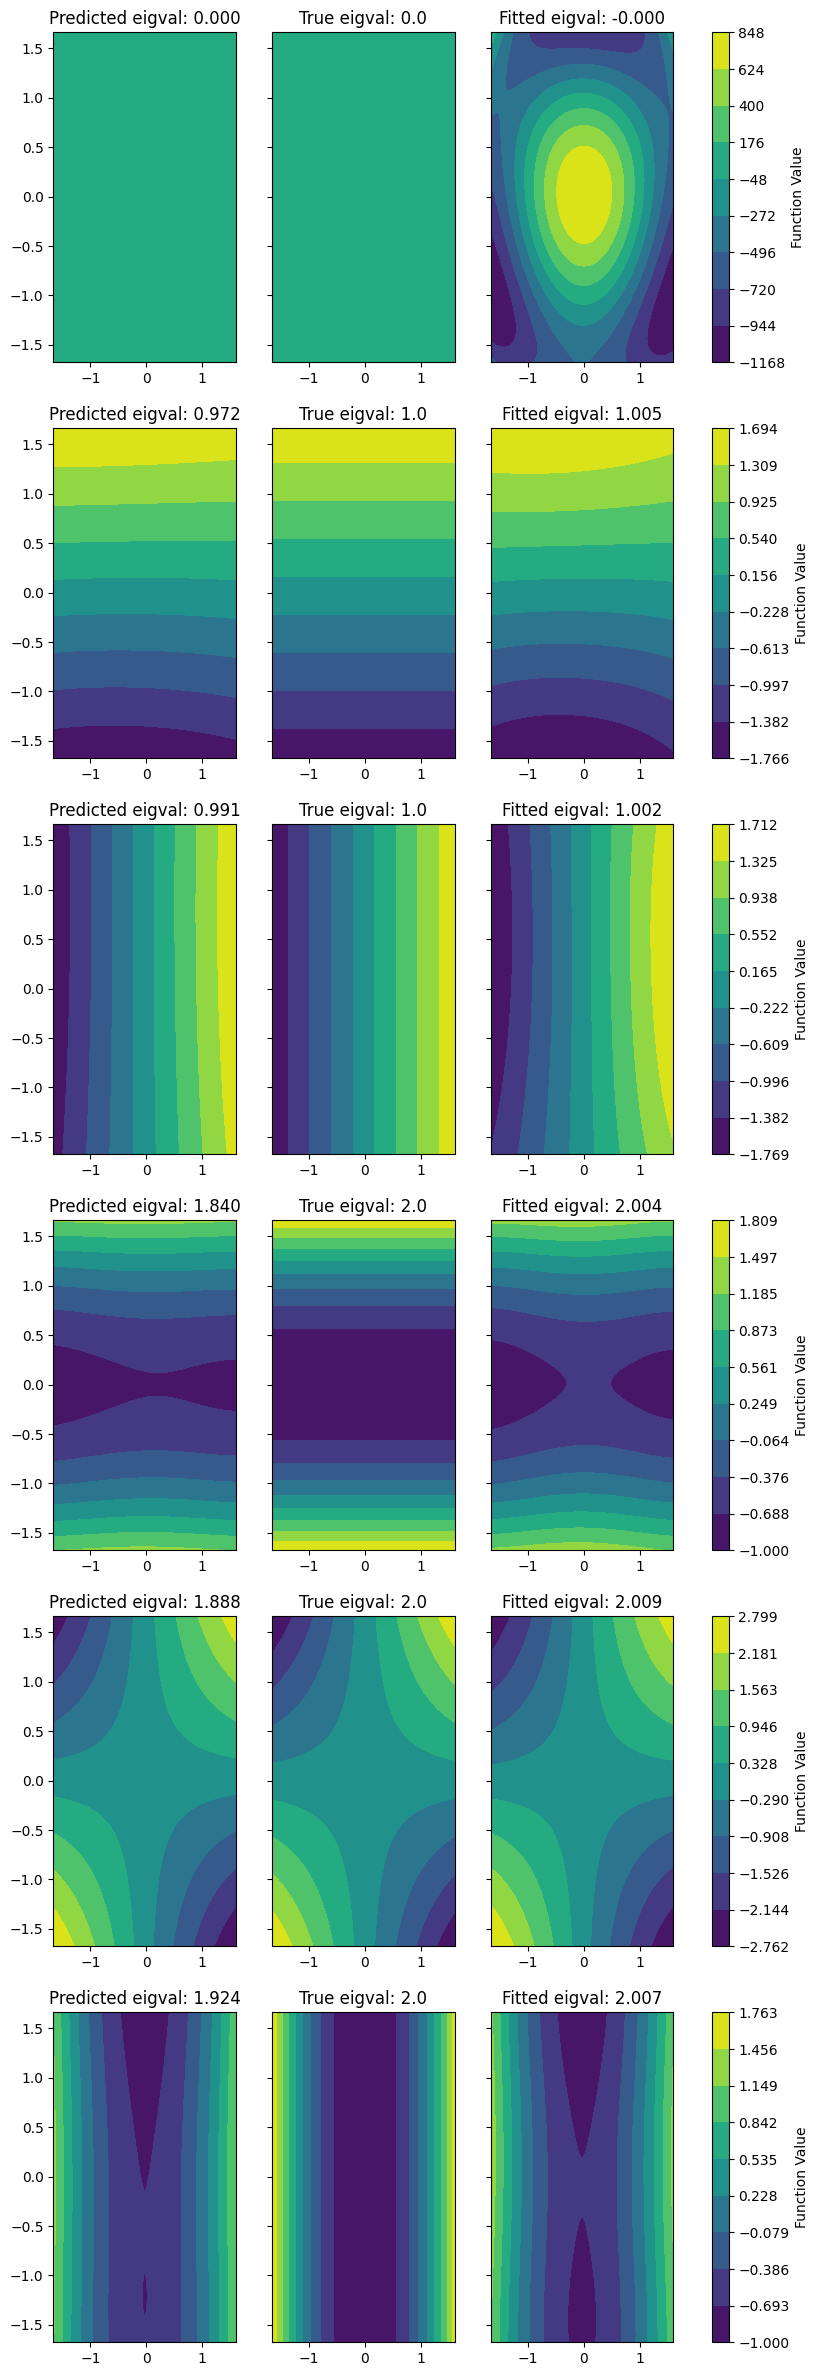

In [17]:
_ = evaluator.plot_eigfuncs_exact(solver,x_eval,6)

## Gaussian Mixture

In [22]:
metrics = ['eigen_error','orth_error','eigen_cost', 'fitted_eigen_error']

dim = 2

experiment_params = {
    'kernel_params': {
        'dim': dim,
        'p': 300,
        'scale': 10.0,
        'order': 3
    },
    'solver_params': {
        'regularizer': 0.0,
        'L_reg': 1e-6,
        'verbose': False,
        'k': 200
    }
}

#means = np.array([np.zeros(dim),np.zeros(dim)])
#covs = np.array([np.diag(0.5+np.random.random(dim)),np.diag(0.5+np.random.random(dim))])

means = np.array([[0,0],[0,0]])
covs = np.array([[[5,0],[0,1]], [[1,0],[0,5]]])

#means = np.array([[0], [5]])
#covs = np.array([[[1]], [[1]]])
w = np.array([0.5,0.5])

energy = GaussianMixture(w,means,covs)
x, solver = kernel_experiment(experiment_params, energy, GaussianKernel)

if solver is None:
    print('Error')
else:
    evaluator = EigenEvaluator(energy)
    x_eval = energy.exact_sample((10000,))

    out = evaluator.evaluate_metrics(solver, x_eval, metrics, k = experiment_params['solver_params']['k'])
    for metric in metrics:
        print(f'{metric}: {out[metric]}')

eigen_error: [5.88136778e-08 1.36129222e-02 1.93353808e-02 2.04549696e-02
 2.55177458e-02 2.24941249e-02 6.12769395e-02 2.07245051e-01
 6.26848427e-01 7.93727292e+00 5.37261881e+01 2.86007655e+04
 6.99821015e+05 1.16547355e+07 3.07345912e+07 6.76155887e+09
 5.12473351e+10 3.28820478e+11 5.21378027e+11 7.17840896e+11
 6.83985049e+11 6.66487546e+11 6.42088400e+11 6.16473095e+11
 5.95099009e+11 5.73651820e+11 5.55565328e+11 5.37423693e+11
 5.20832919e+11 5.04929464e+11 4.89309915e+11 4.74179935e+11
 4.61832645e+11 4.49494868e+11 4.36909537e+11 4.25152653e+11
 4.15082019e+11 4.04458198e+11 3.94696051e+11 3.90833841e+11
 3.82972328e+11 3.77259480e+11 3.69447612e+11 3.62189992e+11
 3.56565397e+11 3.50718977e+11 3.43880607e+11 3.36923525e+11
 3.30354016e+11 3.24392959e+11 3.18865021e+11 3.14492466e+11
 3.10010285e+11 3.05477548e+11 3.02159621e+11 2.97204803e+11
 2.92773146e+11 2.89311465e+11 2.85322281e+11 2.80969473e+11
 2.76990339e+11 2.72867772e+11 2.69766290e+11 2.66340007e+11
 2.62896633

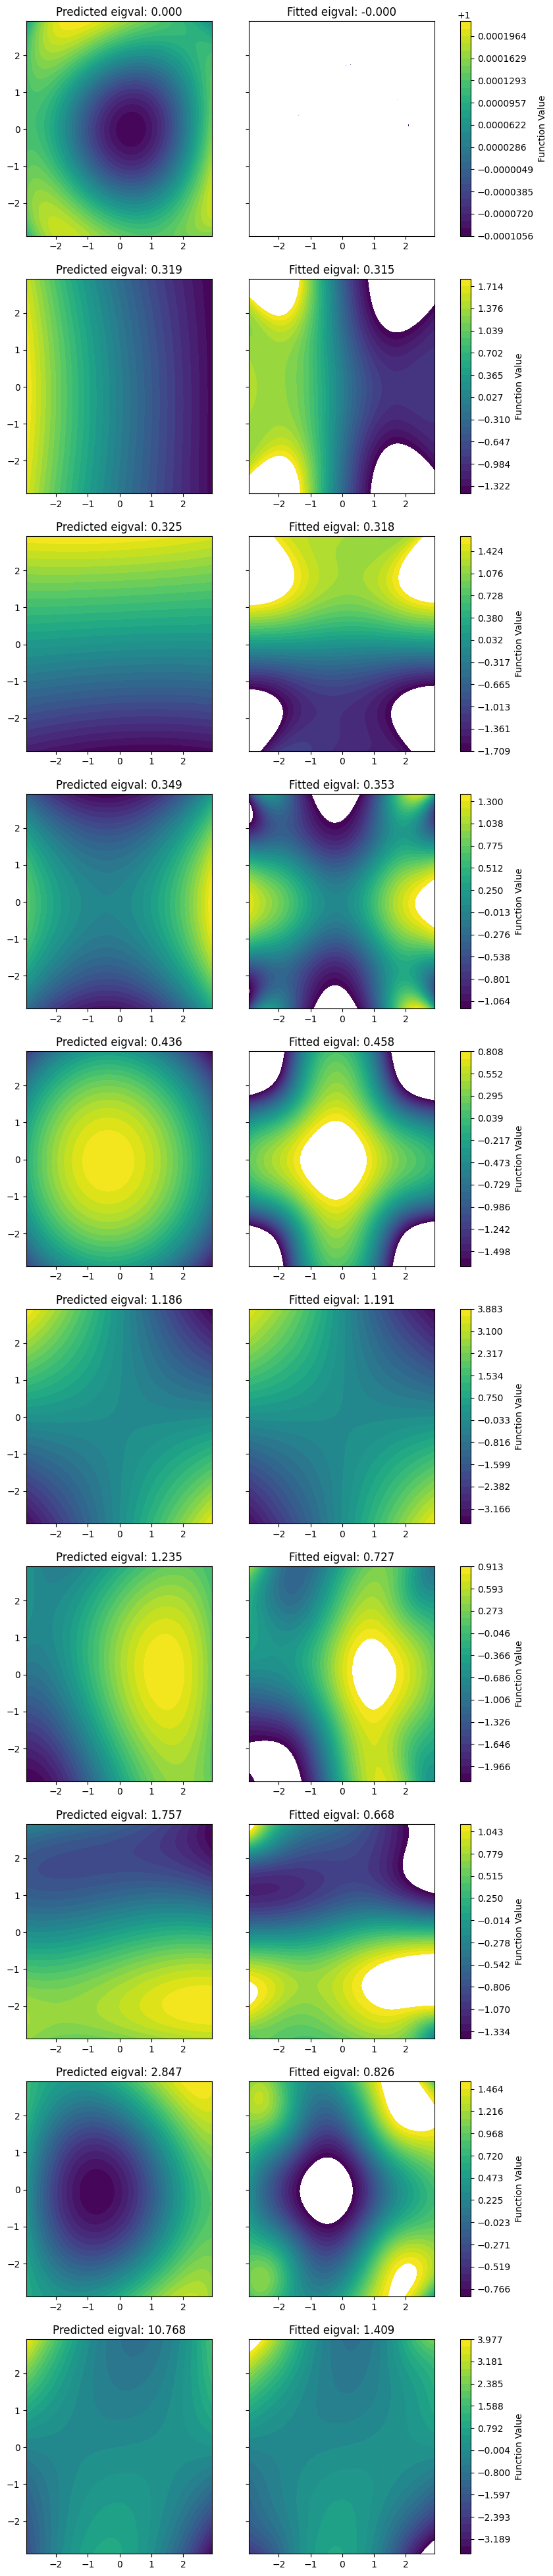

In [23]:
_ = evaluator.plot_eigfuncs(solver,x_eval,10)

## Scratch work

In [13]:
# reconstruct |x|^2

x = energy.exact_sample((100000,))
k = 200
eigfuncs = solver.predict(x)
weights = np.array([0]*19 + [1])
func = lambda x: 1/2*np.sum(x**2,axis=1)
fx = func(x)
Lfx = np.sum(energy.grad(x) * x,axis=1) - energy.dim

In [14]:
inner_prods = np.sum(fx[:,None]*eigfuncs,axis=0)/x.shape[0]

In [15]:
errs = []
L_errs = []

for i in range(1,k+1):
    errs.append(1-np.mean((fx - inner_prods[:i]@(eigfuncs[:,:i]).T)**2)/np.mean((func(x) - np.mean(func(x)))**2))
    L_errs.append(1-np.mean((Lfx - (solver.fitted_eigvals[:i]*inner_prods[:i])@(eigfuncs[:,:i]).T)**2)/np.mean(Lfx**2))

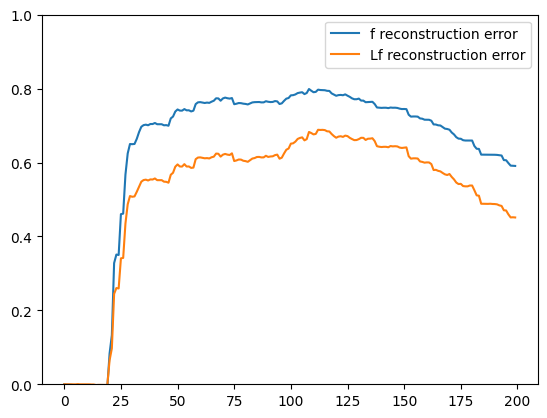

In [16]:
plt.plot(errs, label = 'f reconstruction error')
plt.plot(L_errs, label = 'Lf reconstruction error')

plt.ylim(0,1)
plt.legend()

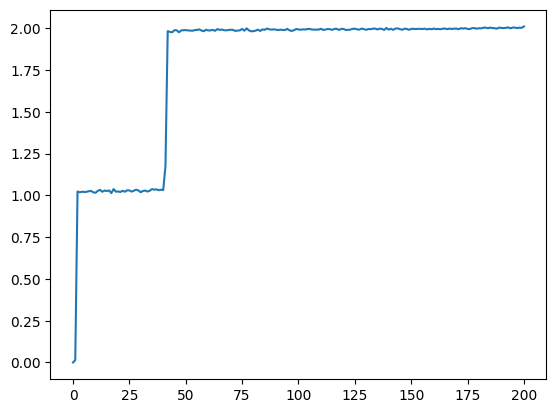

In [347]:
plt.plot(solver.fitted_eigvals, label = 'eigvals')

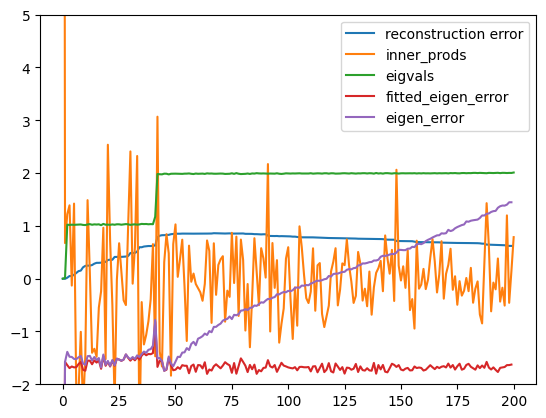

In [348]:
plt.plot(errs, label = 'reconstruction error')
plt.plot(inner_prods, label = 'inner_prods')
plt.plot(solver.fitted_eigvals, label = 'eigvals')
plt.plot(np.log10(out['fitted_eigen_error']),label = 'fitted_eigen_error')
plt.plot(np.log10(out['eigen_error']),label = 'eigen_error')

plt.ylim(-2,5)
plt.legend()

In [149]:
np.mean((func(x) - inner_prods@eigfuncs.T)**2)

np.float64(0.4760264414619271)

In [150]:
np.mean((func(x) - np.mean(func(x)))**2)

np.float64(1.219519479477328)

In [151]:
1-np.mean((func(x) - inner_prods@eigfuncs.T)**2)/np.mean((func(x) - np.mean(func(x)))**2)

np.float64(0.6096606495650676)

### Hyperparameter experiment

In [ ]:

for kernel_scale in tqdm(kernel_scales):
    for p in ps:
        #x, solver = polynomial_kernel_experiment(dim, p, kernel_scale, kernel_order=kernel_order)
        x, solver = gaussian_kernel_experiment(dim, p, kernel_scale)
        
        if solver is not None:
            eigen_errs.append(eigen_error(x,solver,k))
            orth_errs.append(orth_error(x,solver,k))
            L_prod_errs.append(L_prod_error(x,solver,k))
        else:
            eigen_errs.append(np.nan)
            orth_errs.append(np.nan)
            L_prod_errs.append(np.nan)

eigen_errs = np.array(eigen_errs).reshape((len(kernel_scales),len(ps)))
orth_errs = np.array(orth_errs).reshape((len(kernel_scales),len(ps)))
L_prod_errs = np.array(L_prod_errs).reshape((len(kernel_scales),len(ps)))

Text(0, 0.5, 'kernel scale')

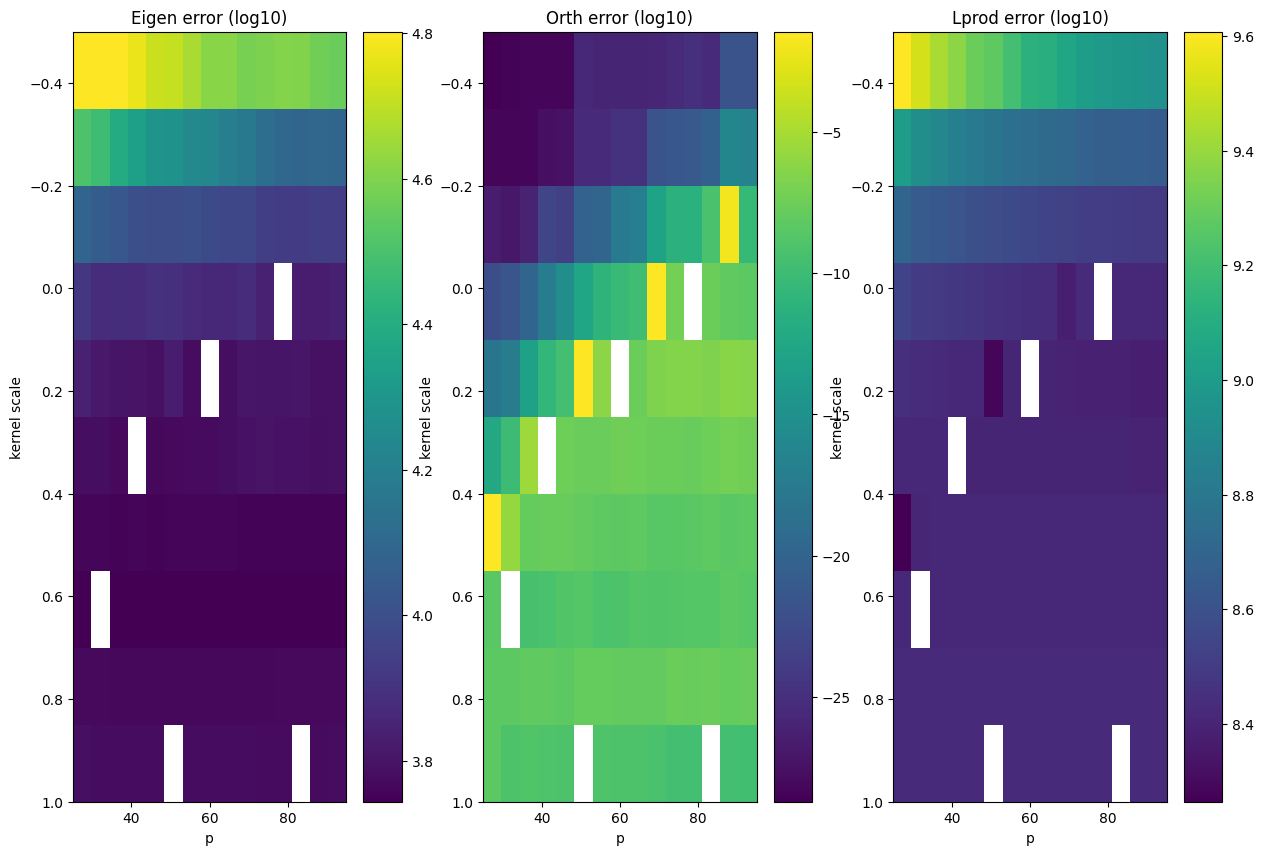

In [31]:
fig, ax = plt.subplots(1,3,figsize=(15,10))

cax = ax[0].imshow(np.log10(eigen_errs),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
cbar = fig.colorbar(cax, ax=ax[0],shrink=1)
ax[0].set_title('Eigen error (log10)')

cax = ax[1].imshow(np.log10(orth_errs),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
cbar = fig.colorbar(cax, ax=ax[1],shrink=1)
ax[1].set_title('Orth error (log10)')

cax = ax[2].imshow(np.log10(L_prod_errs),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
cbar = fig.colorbar(cax, ax=ax[2],shrink=1)
ax[2].set_title('Lprod error (log10)')

ax[0].set_xlabel('p')
ax[0].set_ylabel('kernel scale')
ax[1].set_xlabel('p')
ax[1].set_ylabel('kernel scale')
ax[2].set_xlabel('p')
ax[2].set_ylabel('kernel scale')

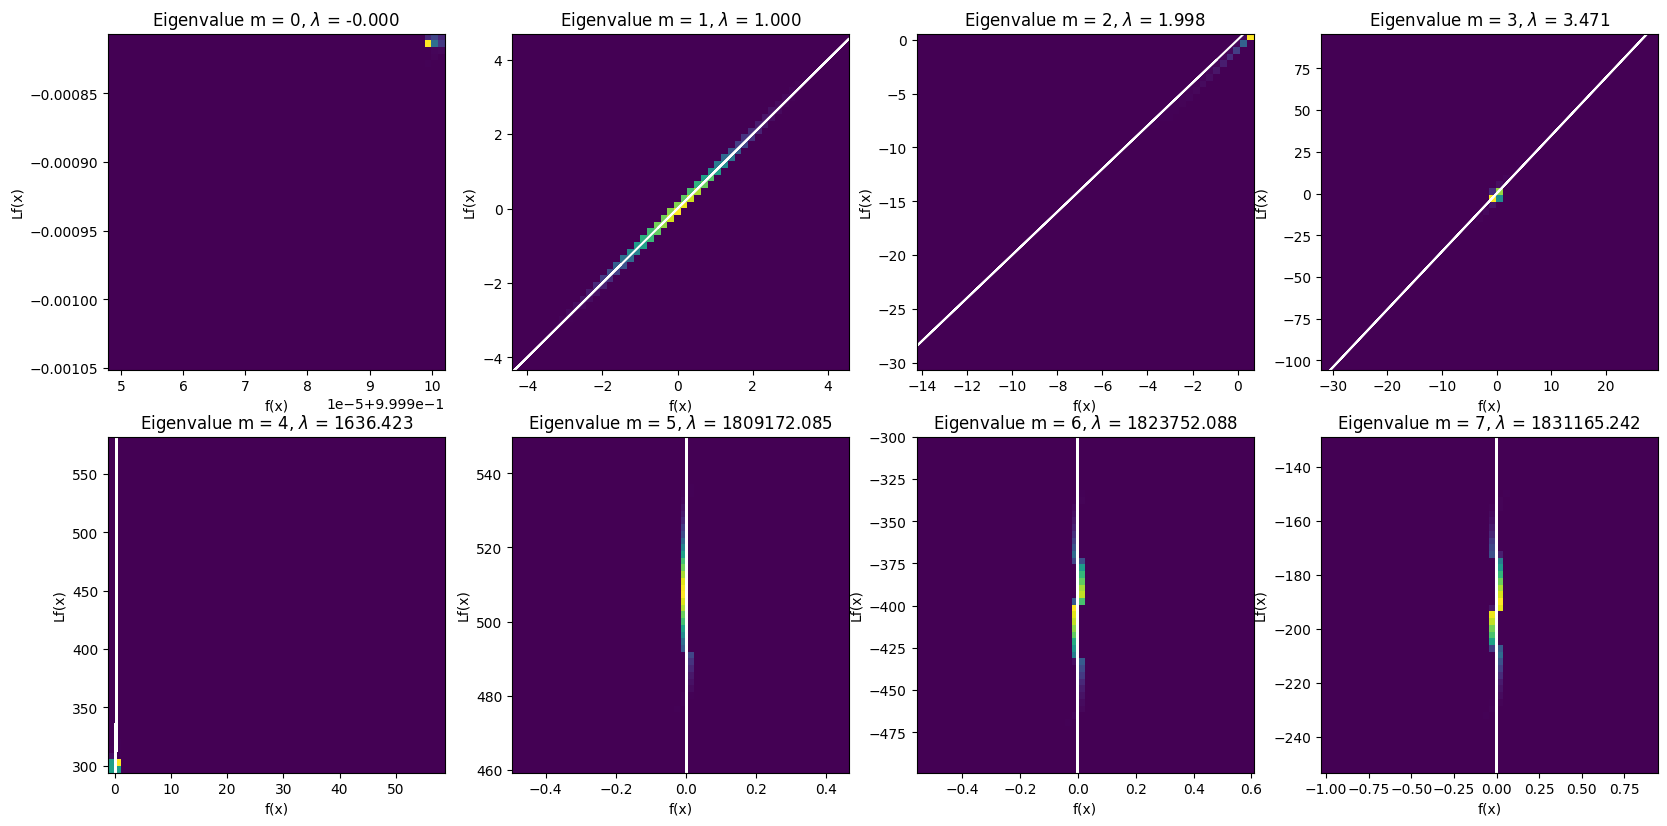

In [64]:
plot_eigenfunctions(x,solver,8)

In [12]:
grad = np.random.standard_normal((1000,100,10))

In [8]:
from itertools import product
import numpy as np

arrays = [np.array([1, 2]), np.array([3, 4]), [5]]
cartesian_product = np.array(list(product(*arrays)))

In [1]:
a = {'b': 1}
c = {'d': 4}

In [8]:
import numpy as np

In [9]:
class TestClass():
    def __init__(self, rng):
        self.rng = np.random.default_rng(rng)

    def random_number(self):
        print(self.rng.random(1))

In [16]:
rng = np.random.default_rng(32)

In [12]:
means = np.array([[0,0],[1,0]])
covs = np.array([np.eye(2),np.eye(2)])
w = np.array([0.5,0.5])

energy = GaussianMixture(w,means,covs)

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [7]:
sample = np.random.multivariate_normal(np.zeros(2), A, size = 10)
        

In [8]:
sample

array([[-1.03591711e+00, -4.38469364e-01],
       [-1.20226348e+00, -5.02518805e-01],
       [-5.90221913e-01, -6.32865982e-01],
       [-1.03081200e-01, -8.50193181e-01],
       [-1.50020486e-01, -3.26154397e-04],
       [ 2.65191361e-01,  9.31788362e-02],
       [ 9.81780193e-01,  2.54230429e-01],
       [ 1.67686907e+00,  3.78149627e-02],
       [-6.33384107e-01, -4.11349989e-01],
       [-1.98442068e-02, -2.65256227e-01]])